# Example for OFFTEIN++ & IoTCloudserve@TEIN  Workshop 2021 

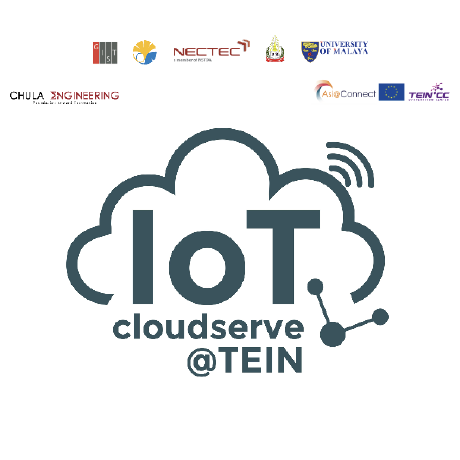

This is the example for IoTFunClass 2021 on 6th Aprill 

URL to use IoTCloudServe : iotcloudserve.net

In this example we will use Covid-19 API to study infected people statistics 

Ref. : https://covid-api.mmediagroup.fr/v1/

Written by IoTcloudServe@TEIN Admin Team 2021
(Kittipat Saengkaenpetch & Natt Visavarungroj) 
    
    Contact : natt.visavarungroj@gmail.com
              kittipat.sae@gmail.com
              
    support by https://github.com/IoTcloudServe
               https://github.com/OFTEIN-NET/OFTEIN-MultiTenantPortal
               https://github.com/benzkittipat/OFTEIN-ML-Showcase
            
              
                  

### Necessary Libraries 

In [15]:
import requests
import pandas as pd
from pandas.io.json import json_normalize
#from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt #ใช้ plot graph
import numpy as np
from sklearn import datasets, neighbors
import itertools
import random
from sklearn.cluster import KMeans
import csv

### Get Response Covid-19 API :  

In [16]:
response = requests.get("https://covid-api.mmediagroup.fr/v1/cases") ## <== Covid-19 Cases API 

### See Response Code (you should get 200 OK)


for more information : https://developer.mozilla.org/en-US/docs/Web/HTTP/Status

In [17]:
print(response.status_code)

200


### Let's see your Raw Data 

In [18]:
print(response.json())


{'Afghanistan': {'All': {'confirmed': 56873, 'recovered': 51940, 'deaths': 2512, 'country': 'Afghanistan', 'population': 35530081, 'sq_km_area': 652090, 'life_expectancy': '45.9', 'elevation_in_meters': None, 'continent': 'Asia', 'abbreviation': 'AF', 'location': 'Southern and Central Asia', 'iso': 4, 'capital_city': 'Kabul', 'lat': '33.93911', 'long': '67.709953', 'updated': '2021/04/07 10:20:52+00'}}, 'Albania': {'All': {'confirmed': 126936, 'recovered': 95035, 'deaths': 2283, 'country': 'Albania', 'population': 2930187, 'sq_km_area': 28748, 'life_expectancy': '71.6', 'elevation_in_meters': None, 'continent': 'Europe', 'abbreviation': 'AL', 'location': 'Southern Europe', 'iso': 8, 'capital_city': 'Tirana', 'lat': '41.1533', 'long': '20.1683', 'updated': '2021/04/07 10:20:52+00'}}, 'Algeria': {'All': {'confirmed': 117879, 'recovered': 82096, 'deaths': 3112, 'country': 'Algeria', 'population': 41318142, 'sq_km_area': 2381741, 'life_expectancy': '69.7', 'elevation_in_meters': 800, 'cont

## Testing Plot Deaths vs 1st 40 days

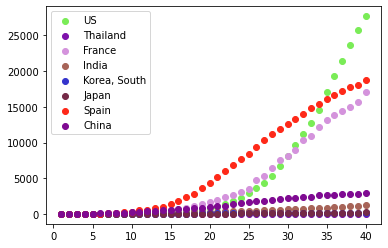

In [19]:
countries = ['US', 'Thailand', 'France', 'India', 'Korea, South', 'Japan', 'Spain', 'China']

colors = itertools.cycle(["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(countries))])


alldata = []

thresholdday = 40

for country in countries:
  
  response = requests.get("https://covid-api.mmediagroup.fr/v1/history?country="+country+"&status=Deaths") 
  jsontest = response.json()

  dates = []

  for date in jsontest["All"]["dates"]:
    if len(dates) < thresholdday:
      # dates.append({'date': date, 'deaths': jsontest["All"]["dates"][date]})
      dates.append(jsontest["All"]["dates"][date])
    elif jsontest["All"]["dates"][date] >= 10:
      dates.pop(0)
      # dates.append({'date': date, 'deaths': jsontest["All"]["dates"][date]})
      dates.append(jsontest["All"]["dates"][date])

  dates.reverse()
  
  alldata.append({"country": country, "deaths": dates})


x = list(range(1, thresholdday+1))

for e in alldata:
  y = e["deaths"]
  plt.scatter(x, y, color=next(colors), label=e["country"])
plt.legend()
# plt.figure(figsize=(6000,3))
plt.show()


## K-Mean 

### Prepare data set X : confirmed Cases  and Y : deaths due to Covid-19 

In [20]:
response = requests.get("https://covid-api.mmediagroup.fr/v1/cases") ## <== Covid-19 Cases API 
# response = requests.get("https://covid-api.mmediagroup.fr/v1/cases?continent=ASIA")
print(response.status_code)
jsontest = response.json()
#print(jsontest)
# print(str(jsontest['All']['confirmed'])+" "+str(jsontest['All']['deaths']))
data = []

for country in jsontest:
    confirmed = jsontest[country]['All']['confirmed']
    deaths = jsontest[country]['All']['deaths']
    recovers = jsontest[country]['All']['recovered']
    data.append({"X": confirmed, "Y": deaths, "country": country})
    #data.append({"X": confirmed, "Y": deaths, "Z": recovers, "country": country})

data2 = pd.DataFrame(data)
print(data2)


df = data2.iloc[:, [0,1]].values
#df = data2.iloc[:, [0,1,2]].values

#df = df.drop(df.tail(len(df)-1).index,inplace=True)

print(df)


200
             X        Y      country
0        56873     2512  Afghanistan
1       126936     2283      Albania
2       117879     3112      Algeria
3        12328      117      Andorra
4        22885      547       Angola
..         ...      ...          ...
188       4975      976        Yemen
189      89071     1224       Zambia
190      36966     1531     Zimbabwe
191   30847737   556529           US
192  132534877  2875876       Global

[193 rows x 3 columns]
[[    56873      2512]
 [   126936      2283]
 [   117879      3112]
 [    12328       117]
 [    22885       547]
 [     1173        29]
 [  2428029     56634]
 [   198898      3647]
 [    29379       909]
 [   566008      9546]
 [   273869      3743]
 [     9270       189]
 [   150811       545]
 [   651652      9384]
 [     3691        43]
 [   329258      2304]
 [   904673     23247]
 [    12477       318]
 [     7313        93]
 [      896         1]
 [   276890     12366]
 [   177506      7052]
 [    41710       616]

### we will train our algorithm by processing all the data. Here the number of clusters will be 5. This number is given arbitrarily by us. we can choose any number to define the number of clusters

In [21]:
kmean=KMeans(n_clusters=5)
label = kmean.fit(df)
label

KMeans(n_clusters=5)

### we can see our 5 centers by using the following command

In [22]:
centriods = kmean.cluster_centers_
centriods
#kmean.n_iter_

array([[1.67123791e+05, 3.11350000e+03],
       [1.32534877e+08, 2.87587600e+06],
       [3.08477370e+07, 5.56529000e+05],
       [1.29511825e+07, 2.51562000e+05],
       [2.76702841e+06, 7.53353529e+04]])

### To check the labels created, we can use the following command. It gives the labels created for our data

In [23]:
labels = kmean.labels_
labels

array([0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1], dtype=int32)

### We are going to use the fit predict method that returns for each observation which cluster it belongs to.it will return this cluster numbers into a single vector that is  called y K-means

In [24]:
y_kmean = kmean.fit_predict(df)
print(y_kmean)
len(y_kmean)

[0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0
 0 0 0 0 0 2 4 4 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 0 0 4 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 4 0 0 0
 0 0 0 0 0 0 3 1]


193

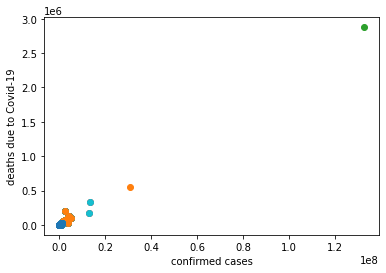

In [25]:
#plotting the results:

for i in y_kmean:
    plt.scatter(df[y_kmean == i , 0], df[y_kmean == i , 1], label = i)
    
#plt.scatter(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.xlabel('confirmed cases')
plt.ylabel('deaths due to Covid-19')
plt.show()

In [26]:
print(labels)
for i in labels:
    data2 = data2.assign(typ = labels[i])
data2

#print(type(data2))


[0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0
 0 0 0 0 0 3 4 4 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 0 0 4 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 4 0 0 0
 0 0 0 0 0 0 2 1]


,X,Y,country,typ
0,56873,2512,Afghanistan,0
1,126936,2283,Albania,0
2,117879,3112,Algeria,0
3,12328,117,Andorra,0
4,22885,547,Angola,0
...,...,...,...,...
188,4975,976,Yemen,0
189,89071,1224,Zambia,0
190,36966,1531,Zimbabwe,0
191,30847737,556529,US,0


### saving output

#### write CSV output file

since data2 is our output file is the panda dataframe, we can use to_csv to convert output to csv. 

In [28]:
data2.to_csv('path/output.csv', index=False)

In [ ]:
## Have fun coding :) 